             Type   x   y  value    Cords
0               H   4  10     27  (4, 10)
1               H   9  10     33  (9, 10)
2               H   1  11     30  (1, 11)
3               H   3   7     24   (3, 7)
4               H   7   6     21   (7, 6)
5               H  10   6     30  (10, 6)
6               H   3   2     27   (3, 2)
7               H   6   3     30   (6, 3)
8               H   9   9     30   (9, 9)
9               H   8   1     30   (8, 1)
10           Hot.   1   1     36   (1, 1)
11           Bank   6   5     39   (6, 5)
12           Shop  11   2     30  (11, 2)
13             Dr   1   7     30   (1, 7)
14           P.O.   8   4     33   (8, 4)
15  Buisness Park   1  12    120  (1, 12)


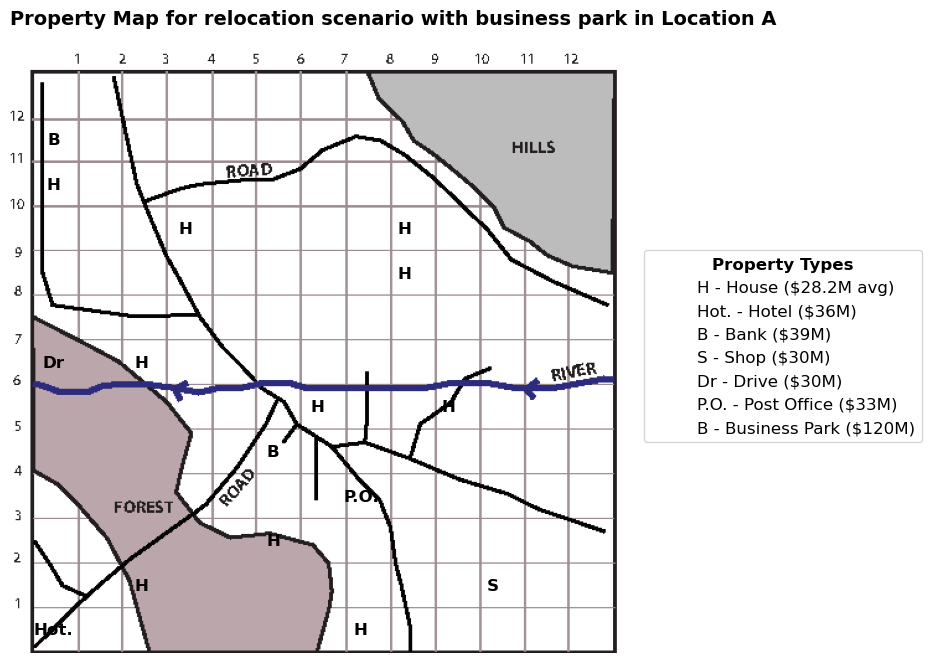

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

setupdirectory = "./Setup-Files/"
outdirectory = "./results/"

relocation = True
buiseness_park_cords = "A"

#getting prop cords and values into a dataframe
props_normal_df = pd.read_csv(setupdirectory + "Buildings_FL_E_1.2_2026.txt", sep="\s+", header=None, engine='python')
props_normal_df = props_normal_df.rename(columns={0: "Type", 1: "x", 2: "y", 3: "value"})
props_normal_df["Cords"] = list(zip(props_normal_df.x, props_normal_df.y))
props_relocation_df = pd.read_csv(setupdirectory + "Buildings_FL_F_1.3_2026.txt", sep="\s+", header=None, engine='python')
props_relocation_df = props_relocation_df.rename(columns={0: "Type", 1: "x", 2: "y", 3: "value"})
props_relocation_df["Cords"] = list(zip(props_relocation_df.x, props_relocation_df.y))

#adding buisness park coordinates to dataframe
if buiseness_park_cords == "A":
    props_normal_df = props_normal_df._append({"Type": "Buisness Park", "x": 1, "y": 12, "value": 120, "Cords": (1, 12)}, ignore_index=True)
    props_relocation_df = props_relocation_df._append({"Type": "Buisness Park", "x": 1, "y": 12, "value": 120, "Cords": (1, 12)}, ignore_index=True)
    #print("Buisness Park added at coordinates (1, 12) with value 120.")
    buiseness_park = True
elif buiseness_park_cords == "B":
    props_normal_df = props_normal_df._append({"Type": "Buisness Park", "x": 5, "y": 6, "value": 60, "Cords": (5, 6)}, ignore_index=True)
    props_relocation_df = props_relocation_df._append({"Type": "Buisness Park", "x": 5, "y": 6, "value": 60, "Cords": (5, 6)}, ignore_index=True)
    #print("Buisness Park added at coordinates (5, 6) with value 60.")
    buiseness_park = True
else:
    buiseness_park = False

#running the simulation
    
if relocation:
    df = props_relocation_df
else:
    df = props_normal_df

print(props_relocation_df)


def plot_property_map(df, relocation, buiseness_park, buiseness_park_cords, map_file="Map_FL_1.0_no_assets.eps"):
    """
    Plot properties on a map image based on their coordinates.
    
    Parameters:
    df: DataFrame with columns 'Type', 'Cords', 'value'
    relocation: Boolean indicating if relocation scenario is used
    buiseness_park: Boolean indicating if business park is included
    buiseness_park_cords: String indicating business park location ('A', 'B', or None)
    map_file: Name of the map file to load from setupdirectory
    """
    # Define abbreviation and label mappings
    abbreviation_map = {
        "H": "H",
        "Hot.": "Hot.",
        "Bank": "B",
        "Shop": "S",
        "Buisness Park": "B",
        "Dr": "Dr",
        "P.O.": "P.O.",
    }

    label_map = {
        "H": "House",
        "Hot.": "Hotel",
        "Bank": "Bank",
        "Shop": "Shop",
        "Buisness Park": "Business Park",
        "Dr": "Drive",
        "P.O.": "Post Office"
    }
    
    # Create a copy to avoid modifying original dataframe
    df_plot = df.copy()
    
    # Add abbreviation and label columns
    df_plot["plot"] = df_plot["Type"].map(abbreviation_map)
    df_plot["label"] = df_plot["Type"].map(label_map)
    
    # Load image
    img = Image.open(setupdirectory + map_file)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)
    
    # Calculate step sizes for grid
    stepsizex = (498 - 18) / 13
    stepsizey = (494 - 27) / 13
    
    # Create coordinate-to-pixel mapping
    chordpixs = {}
    for i in range(1, 13):
        for j in range(1, 13):
            chordpixs[(i, j)] = (18 + i*stepsizex*0.96 - stepsizex/2, 27 + (13-j)*stepsizey + stepsizey/2)
    
    # Plot each property
    for index, row in df_plot.iterrows():
        x, y = row["Cords"]
        if (x, y) in chordpixs:
            pixel_x, pixel_y = chordpixs[(x, y)]
            # Display only abbreviation
            ax.text(pixel_x, pixel_y + 5, row['plot'], 
                   color="black", fontsize=12, fontweight="bold", ha='center')
    
    # Create legend with abbreviation - full name and values
    # For houses, use average value; for others, show unique values
    legend_labels = []
    
    # Add houses with average value
    houses = df_plot[df_plot['Type'] == 'H']
    if not houses.empty:
        avg_house_value = houses['value'].mean()
        legend_labels.append(f"H - House (${avg_house_value:.1f}M avg)")
    
    # Add other property types with their unique values
    other_props = df_plot[df_plot['Type'] != 'H'][['Type', 'plot', 'label', 'value']].drop_duplicates()
    for _, row in other_props.iterrows():
        legend_labels.append(f"{row['plot']} - {row['label']} (${row['value']}M)")
    
    ax.legend(handles=[plt.Line2D([0], [0], color='w', label=label,
                          markerfacecolor='black', markersize=10) for label in legend_labels],
              loc='center left', bbox_to_anchor=(1.02, 0.5), title='Property Types', 
              prop={'size': 12},  # Normal weight for labels
              title_fontproperties={'weight': 'bold', 'size': 12})  # Bold title
    
    # Add title
    title = f"Property Map for {'relocation' if relocation else 'normal'} scenario {f'with business park in Location {buiseness_park_cords}' if buiseness_park else 'without business park'}"
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10, loc='left', x=0)
    
    # Set axis limits to image dimensions to eliminate whitespace
    ax.set_xlim(0, img.size[0])
    ax.set_ylim(img.size[1], 0)
    ax.axis("off")
    
    # Create dynamic filename
    scenario = "relocation" if relocation else "normal"
    bp_suffix = f"_bp_{buiseness_park_cords}" if buiseness_park else "_no_bp"
    filename = f"property_map_{scenario}{bp_suffix}.png"
    
    plt.savefig(outdirectory + filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# Plot the map
plot_property_map(df, relocation, buiseness_park, buiseness_park_cords)
